---
title: "Image matching example with LoFTR"
description: "In this tutorial we are going to show how to perform image matching using a LoFTR algorithm"
author:
    - "Dmytro Mishkin"
date: 09-11-2021
categories:
    - Intermediate
    - LoFTR
    - LAF
    - Image matching
    - kornia.feature
image: "../tutorials/assets/image_matching.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/image_matching.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

First, we will install everything needed:



*  fresh version of [kornia](https://github.com/kornia/kornia) for [LoFTR](https://zju3dv.github.io/loftr/)
*  fresh version of OpenCV for MAGSAC++ geometry estimation
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions and visualization


In [1]:
%%capture
!pip install kornia
!pip install kornia-rs
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [2]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename

In [3]:
url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"

download_image(url_a)
download_image(url_b)

'kn_church-8.jpg'

First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and [MAGSAC++](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/17/OpenCV-New-RANSACs.html) as RANSAC.

In [4]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [5]:
%%capture
fname1 = "overlap1.bmp"
fname2 = "overlap2.bmp"

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (600, 375), antialias=True)
img2 = K.geometry.resize(img2, (600, 375), antialias=True)


matcher = KF.LoFTR(pretrained="outdoor")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

with torch.inference_mode():
    correspondences = matcher(input_dict)

In [6]:
for k, v in correspondences.items():
    print(k)

keypoints0
keypoints1
confidence
batch_indexes


Now let's clean-up the correspondences with modern RANSAC and estimate fundamental matrix between two images

In [7]:
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

Finally, let's draw the matches with a function from [kornia_moons](https://ducha-aiki.github.io/kornia_moons/feature.html#draw_LAF_matches). The correct matches are in green and imprecise matches - in blue

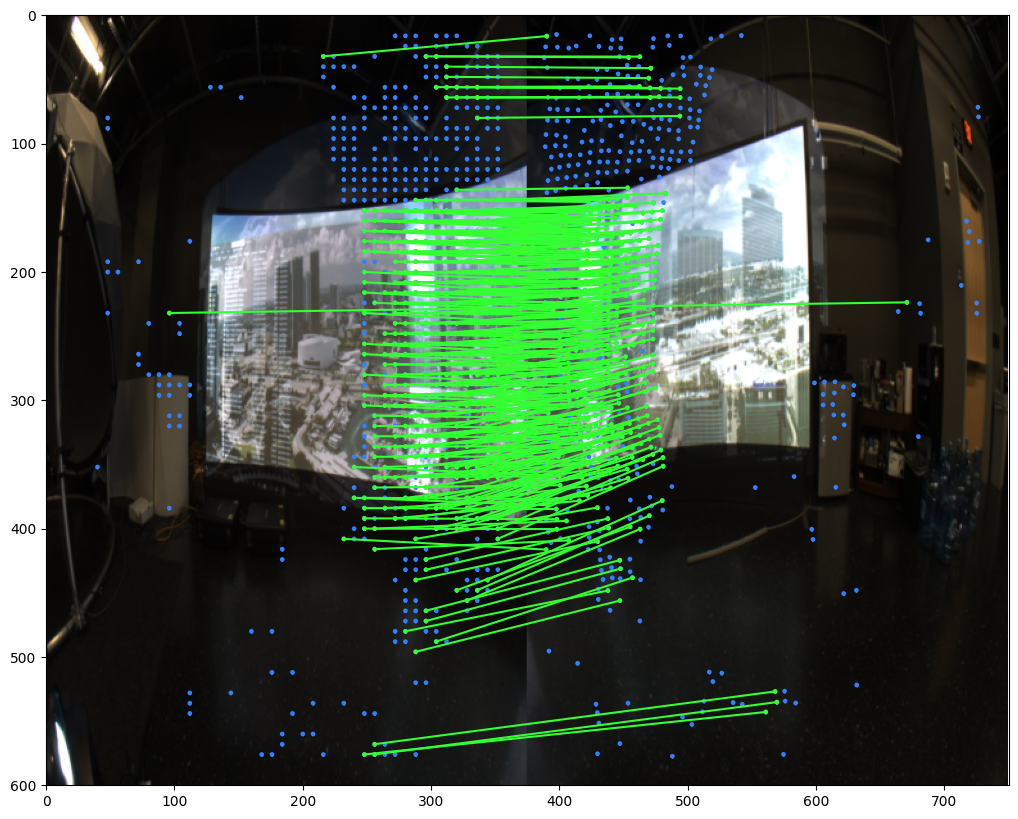

In [8]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
)

## LoFTR Indoor

We recommend to use `KF.LoFTR(pretrained='indoor_new')` and resize images to be not bigger than 640x480 pixels for the `indoor` model.

In [9]:
%%capture

download_image("https://github.com/zju3dv/LoFTR/raw/master/assets/scannet_sample_images/scene0711_00_frame-001680.jpg")
download_image("https://github.com/zju3dv/LoFTR/raw/master/assets/scannet_sample_images/scene0711_00_frame-001995.jpg")

matcher = KF.LoFTR(pretrained="indoor_new")

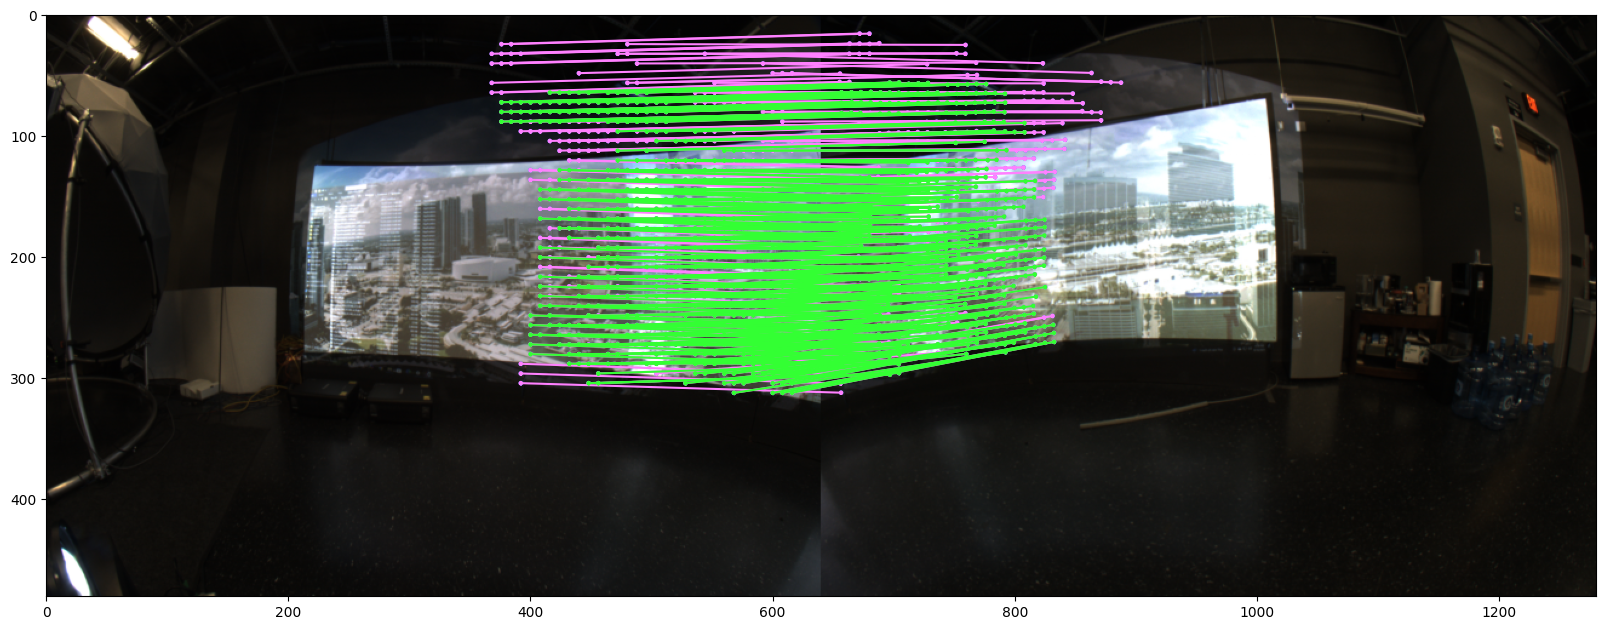

In [10]:
fname1 = "overlap1.bmp"
fname2 = "overlap2.bmp"

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (480, 640), antialias=True)
img2 = K.geometry.resize(img2, (480, 640), antialias=True)

matcher = KF.LoFTR(pretrained="indoor_new")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

with torch.inference_mode():
    correspondences = matcher(input_dict)

mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 1.0, 0.999, 100000)
inliers = inliers > 0

draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)